# Simulate populations of neurons using NEST

In [1]:
!pip install seaborn

In [2]:
import seaborn as sns
import pylab
import numpy as np
import matplotlib.pyplot as plt
import csv
import nest

## Config

In [3]:
np.random.seed(42)

# neurons
exc_cfg = {"I_e": 200.0, "tau_m": 20.0}
nest.CopyModel("iaf_psc_alpha", "exc_iaf_psc_alpha")
nest.SetDefaults("exc_iaf_psc_alpha", exc_cfg)
inh_cfg = {"I_e": 200.}

# populations
inner_connectivity = .1
outer_connectivity = .0025
pop_size = 4175
inh_part = .2

# simulation time
t_sim = 2000.

# spike detectors and multimeters
n_devices = 100

# poisson generators per neuron
# NOTE: much more than 20 are not possible with 16 GB RAM
n_pg = 20

# INTERPOPULATIONAL CONNECTION CASE
"""
0: no connections
1: alpha-gamma, beta-gamma
2: alpha-beta
"""
case = 2

## Create and connect neurons and devices


### Neurons

Each population is composed of 4,175 IAF neurons from which
80% are excitatory.

Each neuron receives a synapse from 10% of randomly selected cells inside its population.

In [4]:
p1 = nest.Create("exc_iaf_psc_alpha", pop_size)
p2 = nest.Create("exc_iaf_psc_alpha", pop_size)
p3 = nest.Create("exc_iaf_psc_alpha", pop_size)

In [5]:
# make 20% of the neurons inhibitory
inh_boundary = int(pop_size * .2)
for p in [p1,p2,p3]:
    for neuron in p[:inh_boundary]:
        nest.SetStatus(neuron, inh_cfg)

In [6]:
# randomize inital membrane voltage
V_range = np.linspace(-77,-55,100)

nest.SetStatus(p1, {"V_m": np.random.choice(V_range)})    
nest.SetStatus(p2, {"V_m": np.random.choice(V_range)})
nest.SetStatus(p3, {"V_m": np.random.choice(V_range)})  

#### Intrapopulational

In [7]:
# index options
opt = np.arange(0, pop_size)
# number of intrapopulational connections
num_inner_conn = int(pop_size * inner_connectivity)
# index border of the inhibitory part
inh_border = int(pop_size * inh_part)

# for each neuron randomize a percentage of the other neurons to be connected to

for i, (n1,n2,n3) in enumerate(zip(p1,p2,p3)):
    
    c1 = np.random.choice(opt, num_inner_conn, replace=False)
    c2 = np.random.choice(opt, num_inner_conn, replace=False)
    c3 = np.random.choice(opt, num_inner_conn, replace=False)
     
    # different weights for inhibitory and excitatory neurons
    nest.Connect(p1[c1[c1 < inh_border]], n1, syn_spec =  {'weight' : -1} )    
    nest.Connect(p1[c1[c1 >= inh_border]], n1)   
    
    nest.Connect(p2[c2[c2 < inh_border]], n2, syn_spec =  {'weight' : -1} )    
    nest.Connect(p2[c2[c2 >= inh_border]], n2)       
    
    nest.Connect(p3[c3[c3 < inh_border]], n3, syn_spec =  {'weight' : -1} )    
    nest.Connect(p3[c3[c3 >= inh_border]], n3)   

#### Interpopulational

In [8]:
opt = np.arange(inh_boundary, pop_size)
num_outer_conn = int(pop_size * outer_connectivity)
for n1,n2,n3 in zip(p1, p2, p3):
    
    if case == 1:
        c13 = np.random.choice(opt, num_outer_conn, replace=False)
        c31 = np.random.choice(opt, num_outer_conn, replace=False)
        c23 = np.random.choice(opt, num_outer_conn, replace=False)
        c32 = np.random.choice(opt, num_outer_conn, replace=False)

        nest.Connect(p1[c13], n3, syn_spec = {'delay': np.random.choice(np.linspace(2,20,100))} ) 
        nest.Connect(p3[c31], n1, syn_spec = {'delay': np.random.choice(np.linspace(2,20,100))} ) 
        nest.Connect(p2[c23], n3, syn_spec = {'delay': np.random.choice(np.linspace(2,20,100))} ) 
        nest.Connect(p3[c32], n2, syn_spec = {'delay': np.random.choice(np.linspace(2,20,100))} ) 
    
    elif case == 2:
        c12 = np.random.choice(opt, num_outer_conn, replace=False)
        c21 = np.random.choice(opt, num_outer_conn, replace=False)

        nest.Connect(p1[c12], n2, syn_spec = {'delay': np.random.choice(np.linspace(2,20,100))} ) 
        nest.Connect(p2[c21], n1, syn_spec = {'delay': np.random.choice(np.linspace(2,20,100))} )

### Poisson generators

In [9]:
pg_cfg = {"rate": 5.}
for i, (n1, n2, n3) in enumerate(zip(p1, p2, p3)):
    pg1 = nest.Create("poisson_generator", n_pg, pg_cfg)
    nest.Connect(pg1, n1)
    
    pg2 = nest.Create("poisson_generator", n_pg, pg_cfg)
    nest.Connect(pg2, n2)
    
    pg3 = nest.Create("poisson_generator", n_pg, pg_cfg)
    nest.Connect(pg3, n3)

### Multimeters ans spike detectors

In [10]:
m = [nest.Create("multimeter", params={"time_in_steps":True, "record_from":["V_m"]}) for _ in range(300)]
s = [nest.Create("spike_detector") for _ in range(300)]
opt_inh = np.arange(0, 835)
opt_exc = np.arange(835, 4175)
num_inh = int(np.around(n_devices * inh_part))
num_exc = int(np.around(n_devices * (1. - inh_part)))

n1_inh = np.random.choice(opt_inh, num_inh, replace=False)
n2_inh = np.random.choice(opt_inh, num_inh, replace=False)
n3_inh = np.random.choice(opt_inh, num_inh, replace=False)

n1_exc = np.random.choice(opt_exc, num_exc, replace=False)
n2_exc = np.random.choice(opt_exc, num_exc, replace=False)
n3_exc = np.random.choice(opt_exc, num_exc, replace=False)

for i in range(num_inh):
    # inhibitory
    nest.Connect(m[n_devices - 1 - i],p1[n1_inh[i]])
    nest.Connect(p1[n1_inh[i]], s[n_devices - 1 - i])
    nest.Connect(m[2 * n_devices - 1 - i],p2[n2_inh[i]])
    nest.Connect(p2[n2_inh[i]], s[2 * n_devices - 1 - i])
    nest.Connect(m[3 * n_devices - 1 - i],p3[n3_inh[i]])
    nest.Connect(p3[n3_inh[i]], s[3 * n_devices - 1 - i])
    
    
for i in range(num_exc):
    # excitatory
    nest.Connect(m[i],p1[n1_exc[i]])
    nest.Connect(p1[n1_exc[i]], s[i])
    nest.Connect(m[i + n_devices],p2[n2_exc[i]])
    nest.Connect(p2[n2_exc[i]], s[i + n_devices])
    nest.Connect(m[i + 2 * n_devices],p3[n3_exc[i]])
    nest.Connect(p3[n3_exc[i]], s[i + 2 * n_devices])

## Simulation and Evaluation

In [11]:
def raster_plot():
    
    num_inh = np.around(n_devices * inh_part)
    num_exc = np.around(n_devices * (1 - inh_part))

    plt.rcParams["figure.figsize"] = (20,10)

    pylab.figure()
    for i, sd in enumerate(s):
        dSD = nest.GetStatus(sd, keys="events")[0]
        ts = dSD["times"]
        if i % n_devices >= num_exc:
            pylab.plot(ts, [i]*len(ts), ".", color="gray", markersize=2)
        else:
            pylab.plot(ts, [i]*len(ts), ".", color="black", markersize=2)


    plt.axhspan(0,num_exc,facecolor="lightblue",alpha=0.2)
    plt.axhspan(num_exc,n_devices,facecolor="lightblue",alpha=0.1)
    plt.axhspan(n_devices,n_devices + num_exc,facecolor="lightgreen",alpha=0.2)
    plt.axhspan(n_devices + num_exc,2 * n_devices,facecolor="lightgreen",alpha=0.1)
    plt.axhspan(2 * n_devices,2 * n_devices + num_exc,facecolor="blue",alpha=0.2)
    plt.axhspan(2 * n_devices + num_exc,3 * n_devices,facecolor="blue",alpha=0.1)
    pylab.title("Raster plot")
    pylab.xlabel("time in ms")
    pylab.ylabel("neuron ID")
    pylab.show()

In [12]:
plt.rcParams["figure.figsize"] = (20,5)

def plot_V(pops=[]):
    
    for idx, multimeter in enumerate(pops):

        dmm = nest.GetStatus(multimeter)[0]
        Vms = dmm["events"]["V_m"]
        ts = dmm["events"]["times"]
        plt.plot(ts, Vms)
    
    pylab.title("Merged V_ms")
    pylab.legend(["alhpa", "beta", "gamma"])
    pylab.xlabel("t")
    pylab.ylabel("V_m")
    pylab.show()

In [13]:
from scipy.spatial import KDTree

def plot_spikes():
    i1 = np.random.randint(n_devices)
    i2 = np.random.randint(n_devices, 2 * n_devices)
    i3 = np.random.randint(2 * n_devices, 3 * n_devices)
    
    sd1 = s[i1]
    sd2 = s[i2]
    sd3 = s[i3]
    
    ts1 = nest.GetStatus(sd1, keys="events")[0]["times"]
    ts2 = nest.GetStatus(sd2, keys="events")[0]["times"]
    ts3 = nest.GetStatus(sd3, keys="events")[0]["times"]
    
    tree1 = KDTree(np.reshape(ts1, (len(ts1), 1)))
    tree2 = KDTree(np.reshape(ts2, (len(ts2), 1)))
    
    nn_dist_12, _ = tree1.query(np.reshape(ts2, (len(ts2), 1)))
    nn_dist_13, _ = tree1.query(np.reshape(ts3, (len(ts3), 1)))
    nn_dist_23, _ = tree2.query(np.reshape(ts3, (len(ts3), 1)))
    
    pylab.figure()
    
    pylab.plot(ts2[1:], nn_dist_12[1:])
    pylab.plot(ts3[1:], nn_dist_13[1:])
    pylab.plot(ts3[1:], nn_dist_23[1:])
    
    pylab.plot(ts1, np.full((len(ts1)), 1), ".")
    pylab.plot(ts2, np.full((len(ts2)), 1), ".")
    pylab.plot(ts3, np.full((len(ts3)), 1), ".")
    
    pylab.title("Spike distances between neurons")
    pylab.legend(["alpha-beta", "alpha-gamma", "beta-gamma"])
    pylab.xlabel("t")
    pylab.ylabel("Distance")
    pylab.show()

In [14]:
def coinc_hists():
    
    # config
    start_idx = 1500
    end_idx = 1800
    threshold = .001
    n_samples = 300
    
    offsets = np.arange(-80, 80, 2)
    hist12 = np.empty((n_samples, len(offsets)))
    hist13 = np.empty((n_samples, len(offsets)))
    hist23 = np.empty((n_samples, len(offsets)))
    
    for sample in range(n_samples):
        
    
        idx1 = np.random.randint(n_devices)
        idx2 = np.random.randint(n_devices, 2 * n_devices)
        idx3 = np.random.randint(2 * n_devices, 3 * n_devices)

        m1 = m[idx1]
        m2 = m[idx2]
        m3 = m[idx3]

        Vms1 = nest.GetStatus(m1)[0]["events"]["V_m"]
        Vms2 = nest.GetStatus(m2)[0]["events"]["V_m"]
        Vms3 = nest.GetStatus(m3)[0]["events"]["V_m"]

        for i, offset in enumerate(offsets):
            diff12 = Vms1[start_idx : end_idx] - Vms2[start_idx + offset: end_idx + offset]
            diff13 = Vms1[start_idx : end_idx] - Vms3[start_idx + offset: end_idx + offset]
            diff23 = Vms2[start_idx : end_idx] - Vms3[start_idx + offset: end_idx + offset]
            hist12[sample, i] = len(diff12[np.abs(diff12) < threshold])
            hist13[sample, i] = len(diff13[np.abs(diff13) < threshold])
            hist23[sample, i] = len(diff23[np.abs(diff23) < threshold])
            
    hist12_mean = np.mean(hist12, axis=0)
    hist13_mean = np.mean(hist13, axis=0)
    hist23_mean = np.mean(hist23, axis=0)
    
    max_y = np.max(hist12_mean) + 1
        
    pylab.figure()
    pylab.title("alpha & beta")
    pylab.bar(offsets, hist12_mean)
    pylab.ylim(0, max_y)
    pylab.show()
    pylab.figure()
    pylab.title("alpha & gamma")
    pylab.bar(offsets, hist13_mean)
    pylab.ylim(0, max_y)
    pylab.show()
    pylab.figure()
    pylab.title("beta & gamma")
    pylab.bar(offsets, hist23_mean)
    pylab.ylim(0, max_y)
    pylab.show()

In [15]:
def firing_hists():

    # config
    start_t = 0
    end_t = 1500
    bin_size = 1.
    
    ts1 = []      
    ts2 = []      
    ts3 = []    
    
    for i in range(n_devices):
        ts1.append(nest.GetStatus(s[i], keys="events")[0]["times"])
        ts2.append(nest.GetStatus(s[i + n_devices], keys="events")[0]["times"])
        ts3.append(nest.GetStatus(s[i + 2 * n_devices], keys="events")[0]["times"])
        
    ts1 = np.hstack(ts1)
    ts2 = np.hstack(ts2)
    ts3 = np.hstack(ts3)
    
    bins = np.arange(start_t, end_t, bin_size)
    
    hist1, _ = np.histogram(ts1, bins=bins)
    hist2, _ = np.histogram(ts2, bins=bins)
    hist3, _ = np.histogram(ts3, bins=bins)
    
    bin_means = (bins - bin_size / 2)[1:]
    
    pylab.figure()
    pylab.plot(bin_means, hist1)
    pylab.plot(bin_means, hist2)
    pylab.plot(bin_means, hist3)
    pylab.legend(["alhpa", "beta", "gamma"])
    pylab.xlabel("t")
    pylab.ylabel("Number of spikes")
    pylab.title("PTSH")
    pylab.show()

In [16]:
def sns_plots():

    # config
    start_idx = 1000
    
    pal = sns.cubehelix_palette(3, rot=-.5, dark=.3)
    
    idx1 = np.random.randint(n_devices)
    idx2 = np.random.randint(n_devices, 2 * n_devices)
    idx3 = np.random.randint(2 * n_devices, 3 * n_devices)

    m1 = m[idx1]
    m2 = m[idx2]
    m3 = m[idx3]

    Vms1 = nest.GetStatus(m1)[0]["events"]["V_m"][start_idx:]
    Vms2 = nest.GetStatus(m2)[0]["events"]["V_m"][start_idx:]
    Vms3 = nest.GetStatus(m3)[0]["events"]["V_m"][start_idx:]

    diff12 = Vms1 - Vms2
    diff13 = Vms1 - Vms3
    diff23 = Vms2 - Vms3
    
    data = [diff12, diff13, diff23]
    sns.violinplot(data=data, palette=pal)

In [17]:
nest.Simulate(t_sim)

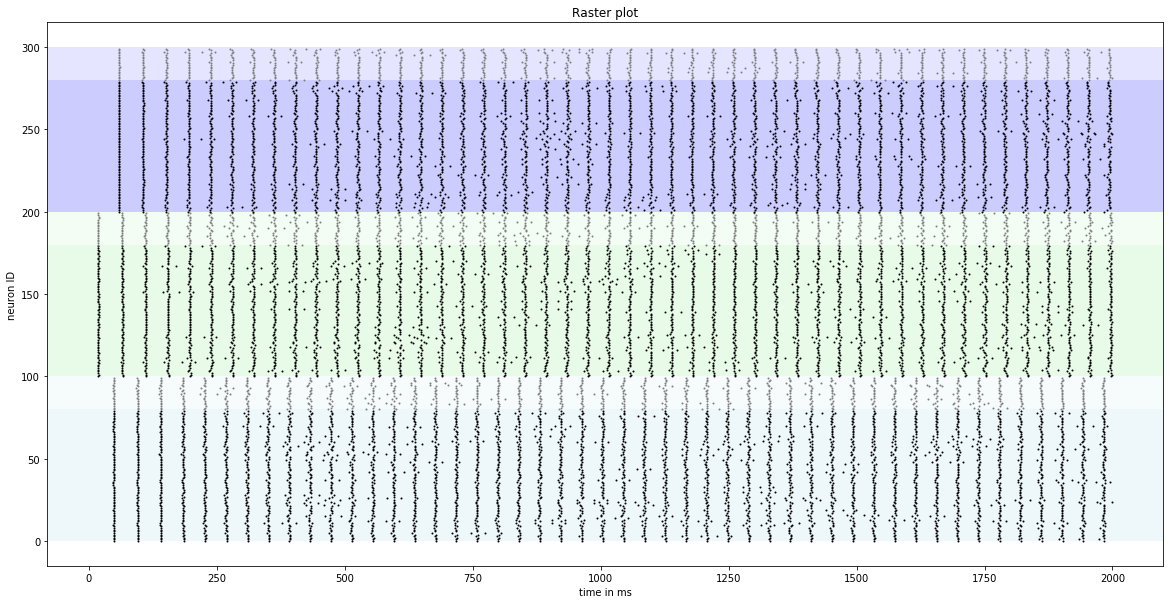

In [18]:
raster_plot()

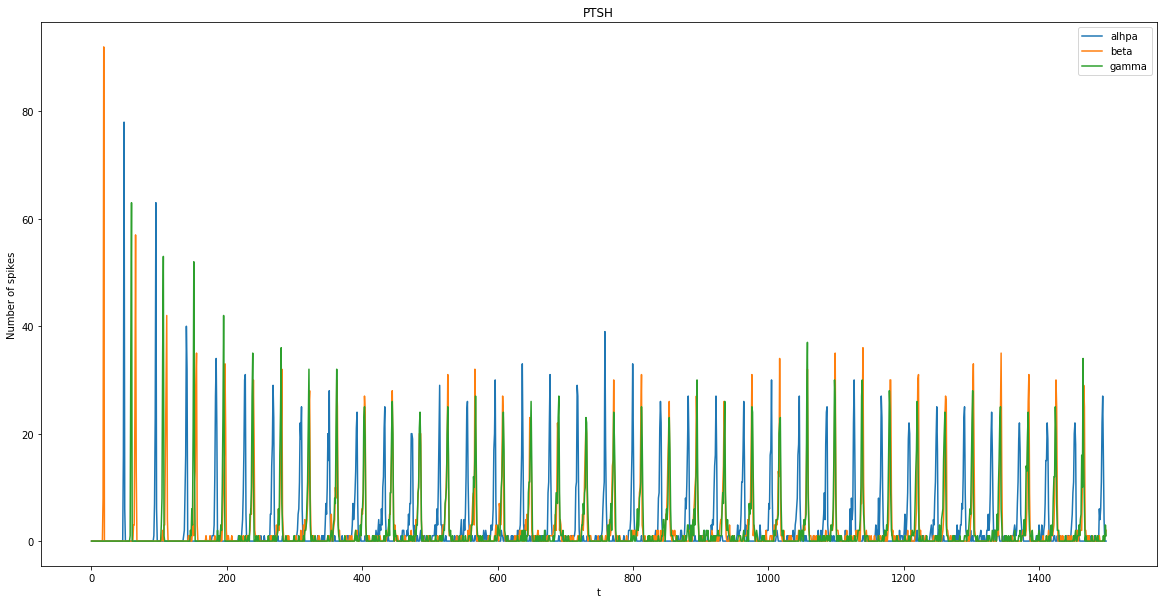

In [19]:
firing_hists()

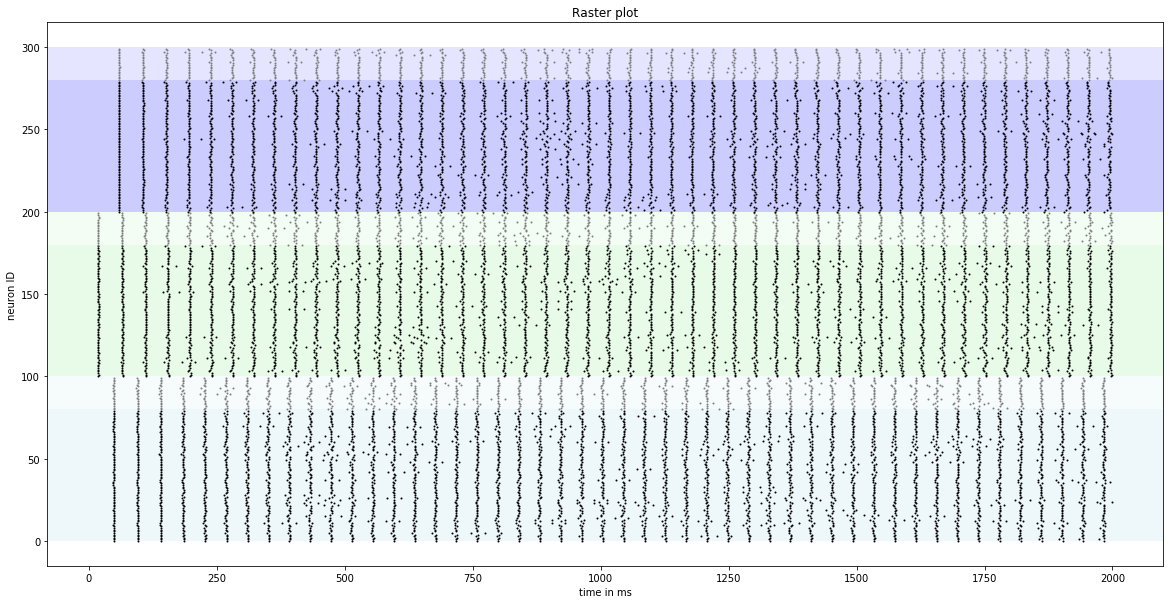

In [20]:
raster_plot()

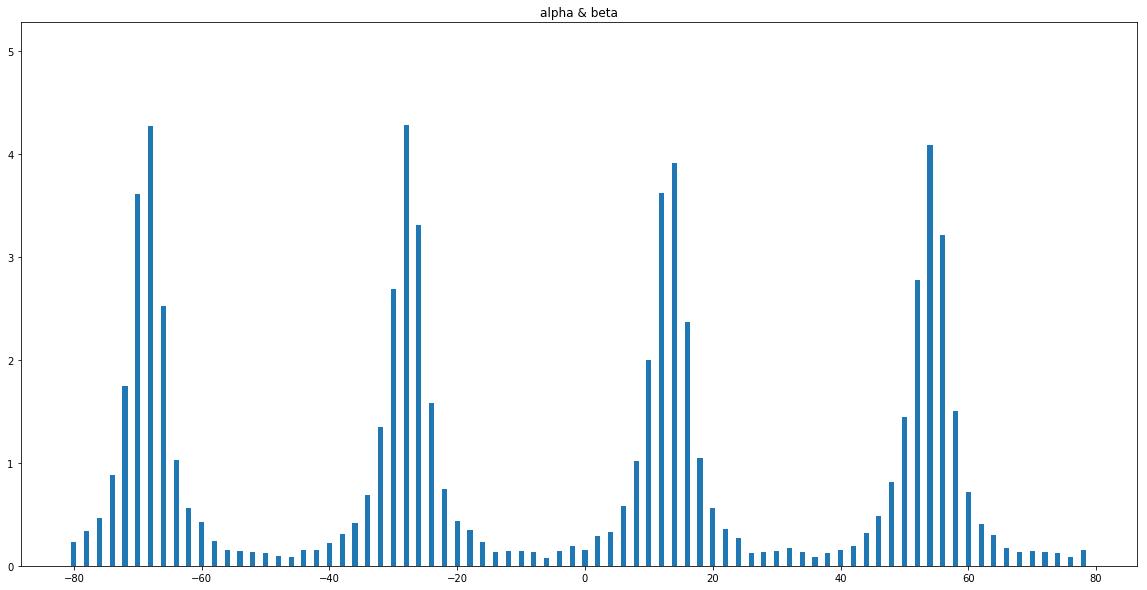

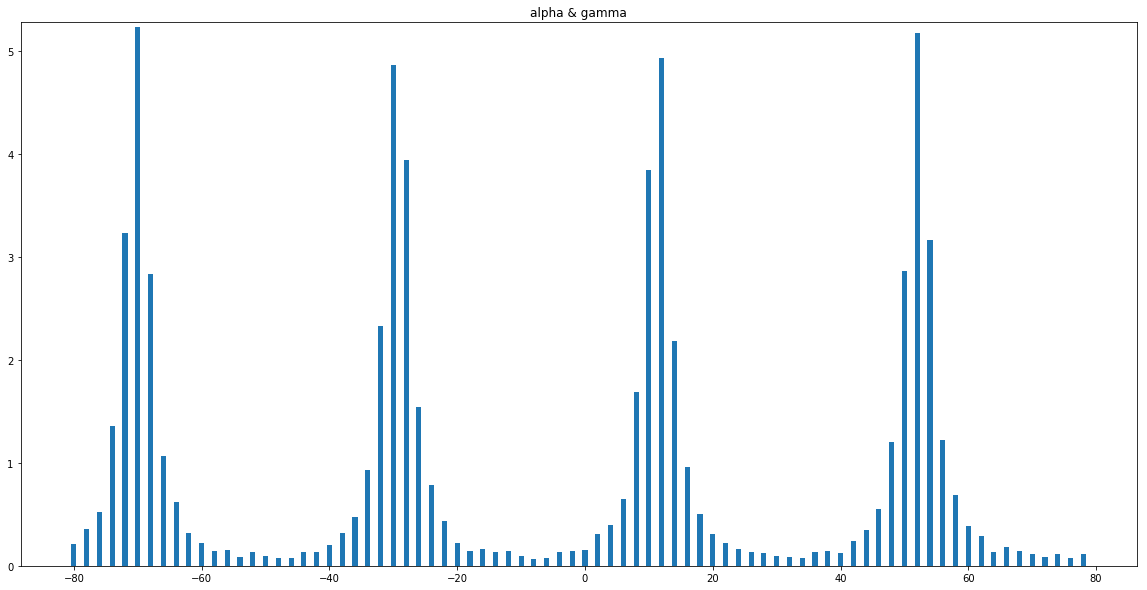

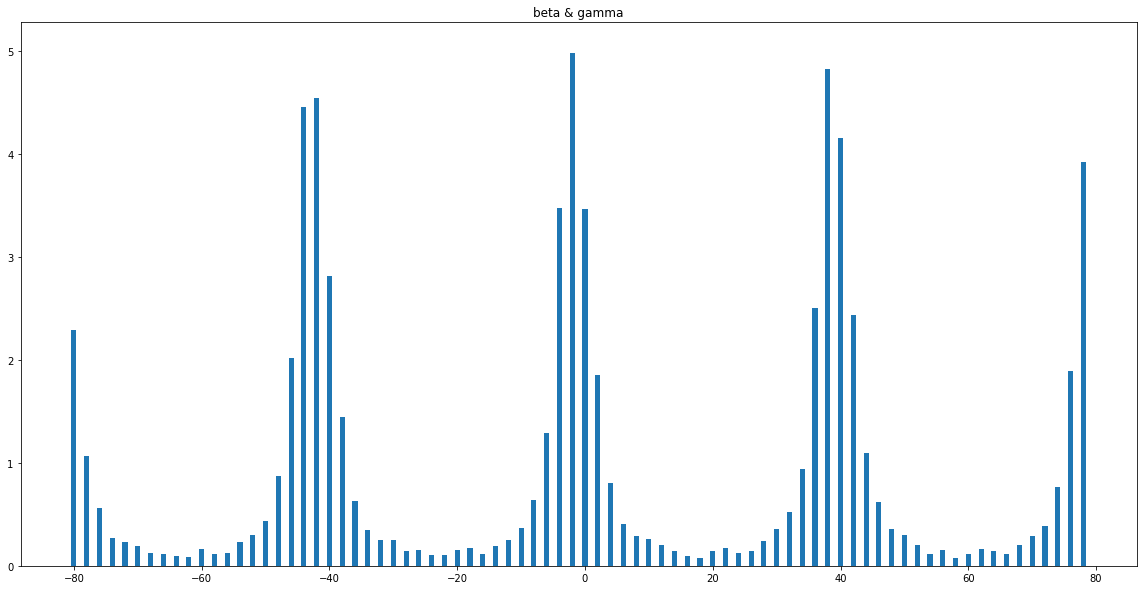

In [21]:
coinc_hists()

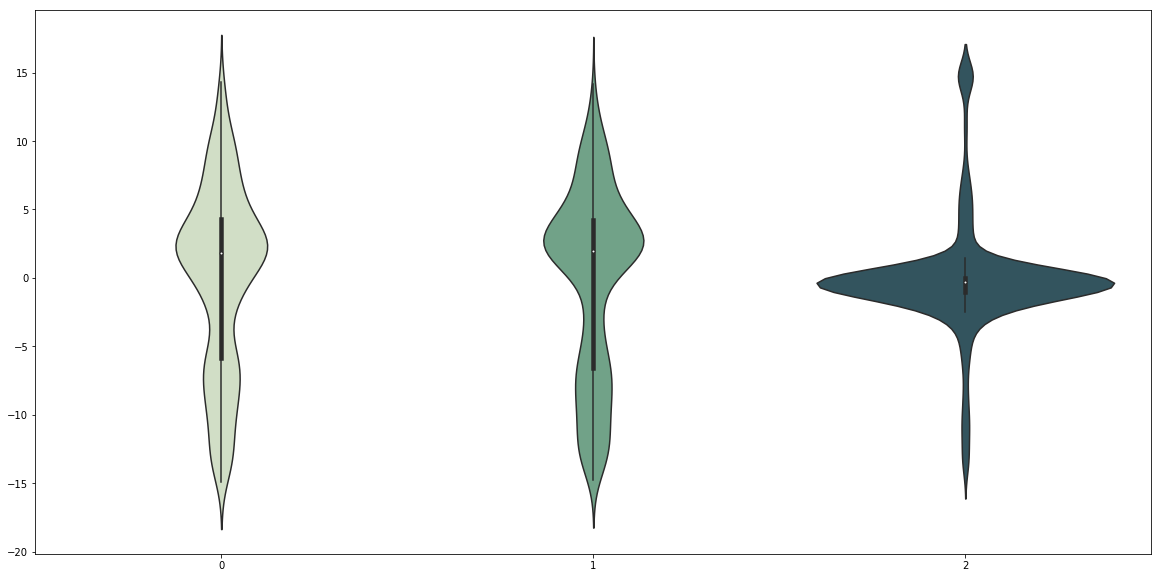

In [22]:
sns_plots()

## Data storage

In [23]:
vm = np.reshape([nest.GetStatus(mult)[0]["events"]["V_m"] for mult in m], (n_devices * 3,int(t_sim) - 1))

with open("vm" + str(case) + ".csv","w+") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(vm)

with open("sd" + str(case) + ".csv","w+") as my_csv:    
    csvWriter = csv.writer(my_csv,delimiter=',')
    for spiked in s:
        csvWriter.writerow(nest.GetStatus(spiked)[0]["events"]["times"])